# Model Evaluation Analysis

This notebook analyzes performance metrics of different models and strategies for generating knowledge graphs from policy documents, focusing on:
- Comparing F1 scores across models and strategies
- Evaluating valid turtle file generation
- Analyzing performance on shorter ground truth files

## Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import os

# Set plot styling
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

## Load and Preprocess Data

We'll load the data containing model outputs, strategies, and ground truth files, then perform necessary preprocessing.

In [2]:
# Define paths to data
data_path_experiment_1 = Path('experiment-1/evaluation_results.csv')
data_path_experiment_2_raw = Path('experiment-2-raw/evaluation_results.csv')
data_path_experiment_2_jsonld = Path('experiment-2-jsonld/evaluation_results.csv')

# Load and merge data, add experiment category
try:
    # Load each experiment's data and add an 'experiment' column
    df1 = pd.read_csv(data_path_experiment_1)
    df1['experiment'] = 'experiment-1'
    # Rename the fine-tuned model for consistency
    df1['model'] = df1['model'].replace({'ft:gpt-4o-mini-2024-07-18:pd-berater-der-ffentlichen-hand:polianna-turtle:BOPrF1gr': 'gpt-4o-mini-ft'})
    # remove lines that contains a model called deepseek
    df1 = df1[~df1['model'].str.contains('deepseek', na=False)]

    df2_raw = pd.read_csv(data_path_experiment_2_raw)
    df2_raw['experiment'] = 'experiment-2-raw'

    df2_jsonld = pd.read_csv(data_path_experiment_2_jsonld)
    df2_jsonld['experiment'] = 'experiment-2-jsonld'

    # Standardize column names if necessary (optional, only if columns differ)
    # For example:
    # df2_raw.rename(columns={'gt_triplet_count': 'ground_truth_triple_count'}, inplace=True)
    # df2_jsonld.rename(columns={'gt_triplet_count': 'ground_truth_triple_count'}, inplace=True)

    # Concatenate all dataframes
    df = pd.concat([df1, df2_raw, df2_jsonld], ignore_index=True)
    print(f"Combined data loaded successfully with {len(df)} rows")
    print(f"Columns: {df.columns.tolist()}")
    df.head()
    # save the combined dataframe to a CSV file
    df.to_csv('combined_evaluation_results.csv', index=False)

except FileNotFoundError:
    print("Data file not found. Please update the path.")
    # Create sample data for demonstration
    print("Creating sample data for demonstration...")

    models = ['GPT-4', 'Claude-3', 'Llama-3', 'Mistral']
    strategies = ['Direct-to-Turtle', 'Extract-then-Convert', 'Triplet-Based', 'Template-Guided']
    files = [f"policy_{i}" for i in range(1, 21)]
    experiments = ['experiment-1', 'experiment-2-raw', 'experiment-2-jsonld']

    data = []
    np.random.seed(42)
    for exp in experiments:
        for file in files:
            file_length = np.random.randint(10, 100)
            file_text_length = file_length * 30
            for model in models:
                for strategy in strategies:
                    precision = np.random.uniform(0.5, 0.95)
                    recall = np.random.uniform(0.5, 0.95)
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    valid_turtle = np.random.choice([True, False], p=[0.8, 0.2])
                    data.append({
                        'model': model,
                        'strategy': strategy,
                        'ground_truth_file': file,
                        'ground_truth_triple_count': file_length,
                        'ground_truth_text_length': file_text_length,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1,
                        'is_valid': valid_turtle,
                        'experiment': exp
                    })
    df = pd.DataFrame(data)
    print("Sample data created.")
    df.head()

Combined data loaded successfully with 1176 rows
Columns: ['article_id', 'model', 'strategy', 'is_valid', 'syntax_errors', 'precision', 'recall', 'f1_score', 'true_positives', 'false_positives', 'false_negatives', 'tp_core', 'fp_core', 'fn_core', 'precision_core', 'recall_core', 'f1_score_core', 'tp_policy_char', 'fp_policy_char', 'fn_policy_char', 'precision_policy_char', 'recall_policy_char', 'f1_score_policy_char', 'tp_compliance_char', 'fp_compliance_char', 'fn_compliance_char', 'precision_compliance_char', 'recall_compliance_char', 'f1_score_compliance_char', 'tp_actor', 'fp_actor', 'fn_actor', 'precision_actor', 'recall_actor', 'f1_score_actor', 'tp_other', 'fp_other', 'fn_other', 'precision_other', 'recall_other', 'f1_score_other', 'tp_time', 'fp_time', 'fn_time', 'precision_time', 'recall_time', 'f1_score_time', 'property_precision', 'property_recall', 'property_f1_score', 'property_true_positives', 'property_false_positives', 'property_false_negatives', 'property_diversity', '

In [3]:
print(df)

                                             article_id              model  \
0     EU_32012L0027_Title_0_Chapter_3_Section_0_Arti...     gpt-4o-mini-ft   
1     EU_32012L0027_Title_0_Chapter_3_Section_0_Arti...     gpt-4o-mini-ft   
2     EU_32012L0027_Title_0_Chapter_3_Section_0_Arti...     gpt-4o-mini-ft   
3     EU_32012L0027_Title_0_Chapter_3_Section_0_Arti...  gpt-4o-2024-08-06   
4     EU_32012L0027_Title_0_Chapter_3_Section_0_Arti...  gpt-4o-2024-08-06   
...                                                 ...                ...   
1171  EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...  qwen2.5-coder:32b   
1172  EU_32008R1099_Title_0_Chapter_0_Section_0_Arti...  gpt-4o-2024-08-06   
1173  EU_32008R1099_Title_0_Chapter_0_Section_0_Arti...  gpt-4o-2024-08-06   
1174  EU_32008R1099_Title_0_Chapter_0_Section_0_Arti...  qwen2.5-coder:32b   
1175  EU_32008R1099_Title_0_Chapter_0_Section_0_Arti...  qwen2.5-coder:32b   

       strategy  is_valid  syntax_errors  precision    recall  

## Experiment 1

## Count Valid Turtles Generated Across Strategies

Let's analyze how many valid Turtle files each model and strategy combination produced.

In [4]:
df_1 = df[df['experiment'] == 'experiment-1']

# Count valid Turtle files by model and strategy
valid_turtles = df_1.groupby(['model', 'strategy', 'experiment'])['is_valid'].agg(['sum', 'count']).reset_index()
valid_turtles['percentage'] = (valid_turtles['sum'] / valid_turtles['count'] * 100).round(2)
valid_turtles.columns = ['Model', 'Strategy', 'Experiment', 'Valid Turtles', 'Total Attempts', 'Success Rate (%)']

print("Valid Turtle Generation by Model and Strategy:")
valid_turtles = valid_turtles.sort_values('Success Rate (%)', ascending=False)
print(valid_turtles)

Valid Turtle Generation by Model and Strategy:
                 Model   Strategy    Experiment  Valid Turtles  \
0    gpt-4o-2024-08-06   few-shot  experiment-1             42   
1    gpt-4o-2024-08-06   one-shot  experiment-1             42   
3       gpt-4o-mini-ft   few-shot  experiment-1             42   
4       gpt-4o-mini-ft   one-shot  experiment-1             42   
5       gpt-4o-mini-ft  zero-shot  experiment-1             42   
2    gpt-4o-2024-08-06  zero-shot  experiment-1             41   
10  o3-mini-2025-01-31   one-shot  experiment-1             37   
9   o3-mini-2025-01-31   few-shot  experiment-1             36   
12   qwen2.5-coder:32b   few-shot  experiment-1             33   
13   qwen2.5-coder:32b   one-shot  experiment-1             33   
14   qwen2.5-coder:32b  zero-shot  experiment-1             31   
11  o3-mini-2025-01-31  zero-shot  experiment-1             29   
16         qwen2.5:32b   one-shot  experiment-1             29   
17         qwen2.5:32b  zero-

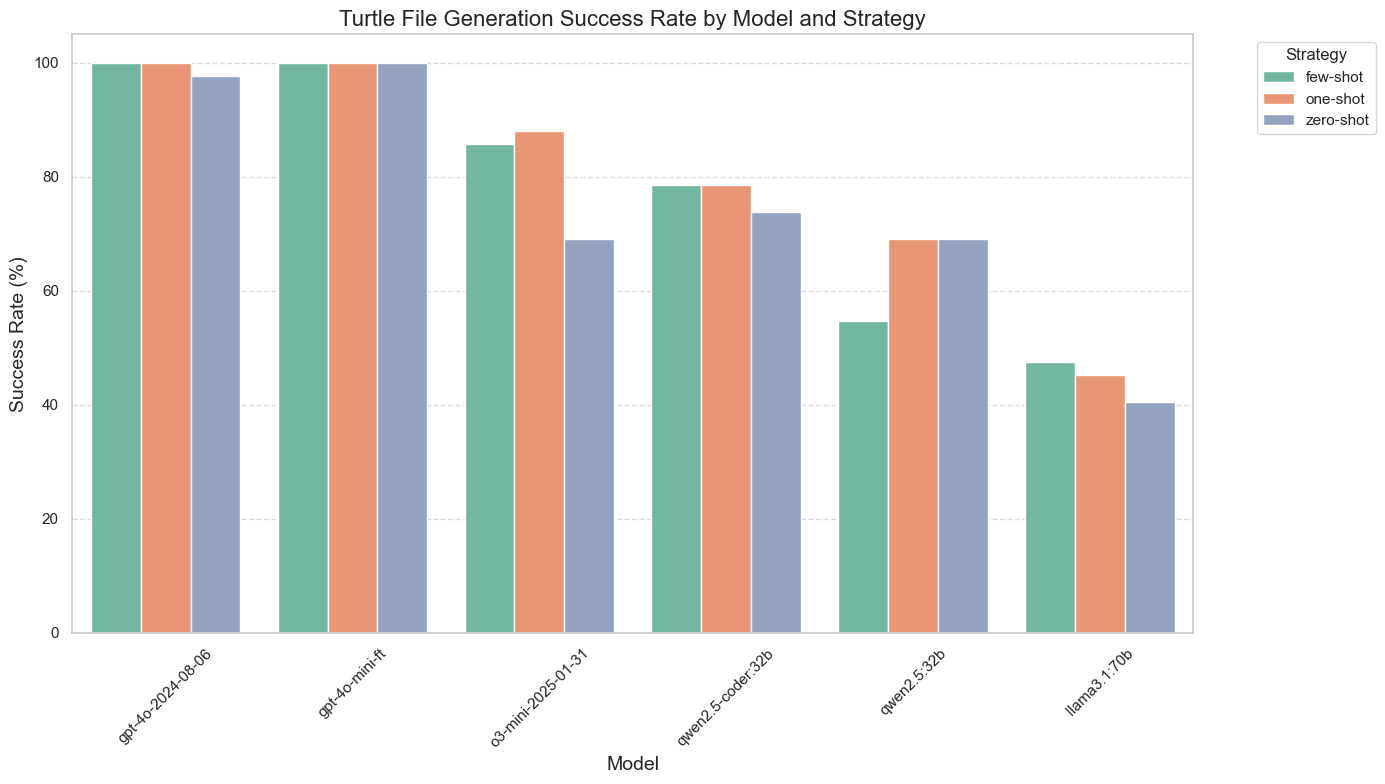

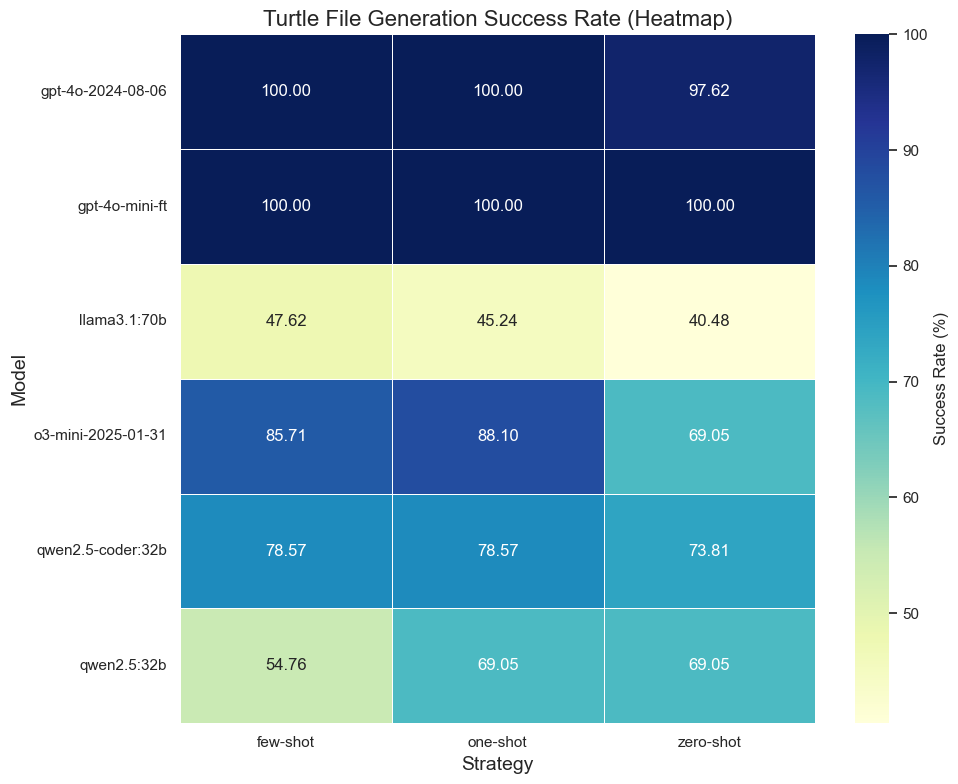

In [5]:
# Create a grouped bar chart for valid turtle percentages
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Success Rate (%)', hue='Strategy', data=valid_turtles, palette='Set2')
plt.title('Turtle File Generation Success Rate by Model and Strategy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

pivot_valid = valid_turtles.pivot(index='Model', columns='Strategy', values='Success Rate (%)')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_valid, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Success Rate (%)'})
plt.title('Turtle File Generation Success Rate (Heatmap)', fontsize=16)
plt.xlabel('Strategy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.tight_layout()
plt.show()

### Compare Recall Score by Model and Strategy

We'll analyze how Recall scores vary across different models and strategies.

In [6]:
# --- Create a filtered DataFrame specifically for Recall analysis ---
print(f"Original DataFrame size for Recall analysis: {len(df)} rows")
df_recall = df_1[df_1['recall'] > 0].copy()
rows_removed_recall = len(df_1) - len(df_recall)
print(f"Removed {rows_removed_recall} rows with zero Recall score for Recall analysis. Using {len(df_recall)} rows.")
# --- End of filtering ---

recall_by_model_strategy = df_recall.groupby(['model', 'strategy'])['recall'].agg(['mean', 'std', 'count']).reset_index()
recall_by_model_strategy.columns = ['model', 'strategy', 'Mean Recall', 'Std Dev', 'Count']
recall_by_model_strategy = recall_by_model_strategy.sort_values(by='Mean Recall', ascending=False)

recall_by_model_strategy

Original DataFrame size for Recall analysis: 1176 rows
Removed 412 rows with zero Recall score for Recall analysis. Using 344 rows.


,model,strategy,Mean Recall,Std Dev,Count
5,gpt-4o-mini-ft,zero-shot,0.836597,0.110288,42
4,gpt-4o-mini-ft,one-shot,0.778811,0.146502,42
3,gpt-4o-mini-ft,few-shot,0.733284,0.157105,42
1,gpt-4o-2024-08-06,one-shot,0.613813,0.142918,42
0,gpt-4o-2024-08-06,few-shot,0.604099,0.143169,42
6,o3-mini-2025-01-31,few-shot,0.580289,0.206578,36
7,o3-mini-2025-01-31,one-shot,0.571898,0.209730,37
2,gpt-4o-2024-08-06,zero-shot,0.293212,0.133284,39
8,o3-mini-2025-01-31,zero-shot,0.183922,0.077589,22


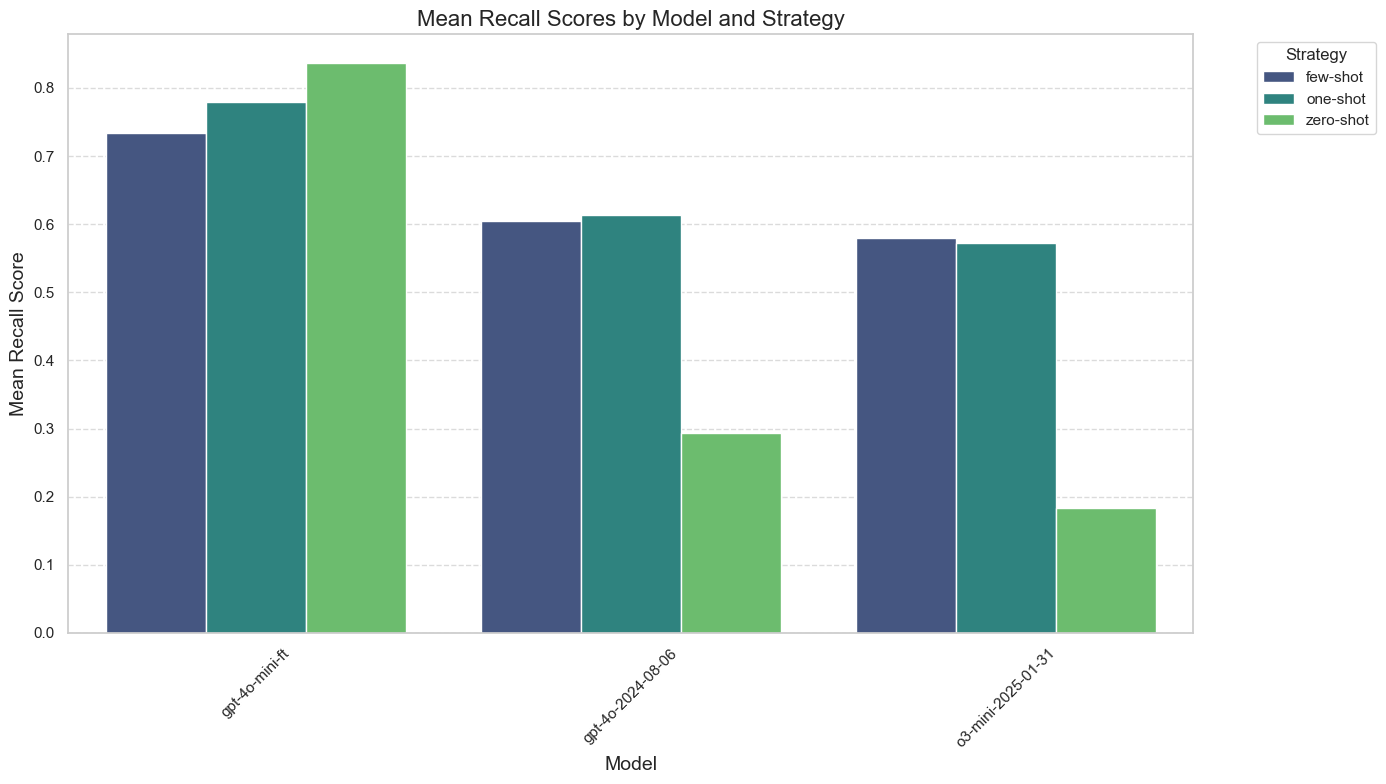

In [7]:
# Create a grouped bar chart of Recall scores by model and strategy
# Reorder strategies for plotting: zero-shot, one-shot, few-shot
strategy_order = ['zero-shot', 'one-shot', 'few-shot']
recall_by_model_strategy['strategy'] = pd.Categorical(recall_by_model_strategy['strategy'], categories=strategy_order, ordered=True)

plt.figure(figsize=(14, 8))
sns.barplot(
    x='model',
    y='Mean Recall',
    hue='strategy',
    data=recall_by_model_strategy,
    hue_order=strategy_order[::-1],  # right to left: zero-shot, one-shot, few-shot
    palette='viridis'
)
plt.title('Mean Recall Scores by Model and Strategy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Recall Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Compare Precision Score by Model and Strategy

We'll analyze how Recall scores vary across different models and strategies.

In [8]:
# --- Create a filtered DataFrame specifically for Precision analysis ---
print(f"Original DataFrame size for Precision analysis: {len(df_1)} rows")
df_precision = df_1[df_1['precision'] > 0].copy()
rows_removed_precision = len(df_1) - len(df_precision)
print(f"Removed {rows_removed_precision} rows with zero Precision score for Precision analysis. Using {len(df_precision)} rows.")
# --- End of filtering ---

precision_by_model_strategy = df_precision.groupby(['model', 'strategy'])['precision'].agg(['mean', 'std', 'count']).reset_index()
precision_by_model_strategy.columns = ['model', 'strategy', 'Mean Precision', 'Std Dev', 'Count']
precision_by_model_strategy = precision_by_model_strategy.sort_values(by='Mean Precision', ascending=False)

precision_by_model_strategy

Original DataFrame size for Precision analysis: 756 rows
Removed 412 rows with zero Precision score for Precision analysis. Using 344 rows.


,model,strategy,Mean Precision,Std Dev,Count
4,gpt-4o-mini-ft,one-shot,0.649657,0.141822,42
5,gpt-4o-mini-ft,zero-shot,0.632725,0.138894,42
3,gpt-4o-mini-ft,few-shot,0.593171,0.140680,42
1,gpt-4o-2024-08-06,one-shot,0.564723,0.139030,42
0,gpt-4o-2024-08-06,few-shot,0.485753,0.130793,42
7,o3-mini-2025-01-31,one-shot,0.307808,0.170279,37
2,gpt-4o-2024-08-06,zero-shot,0.280160,0.145706,39
6,o3-mini-2025-01-31,few-shot,0.264932,0.122534,36
8,o3-mini-2025-01-31,zero-shot,0.061525,0.027716,22


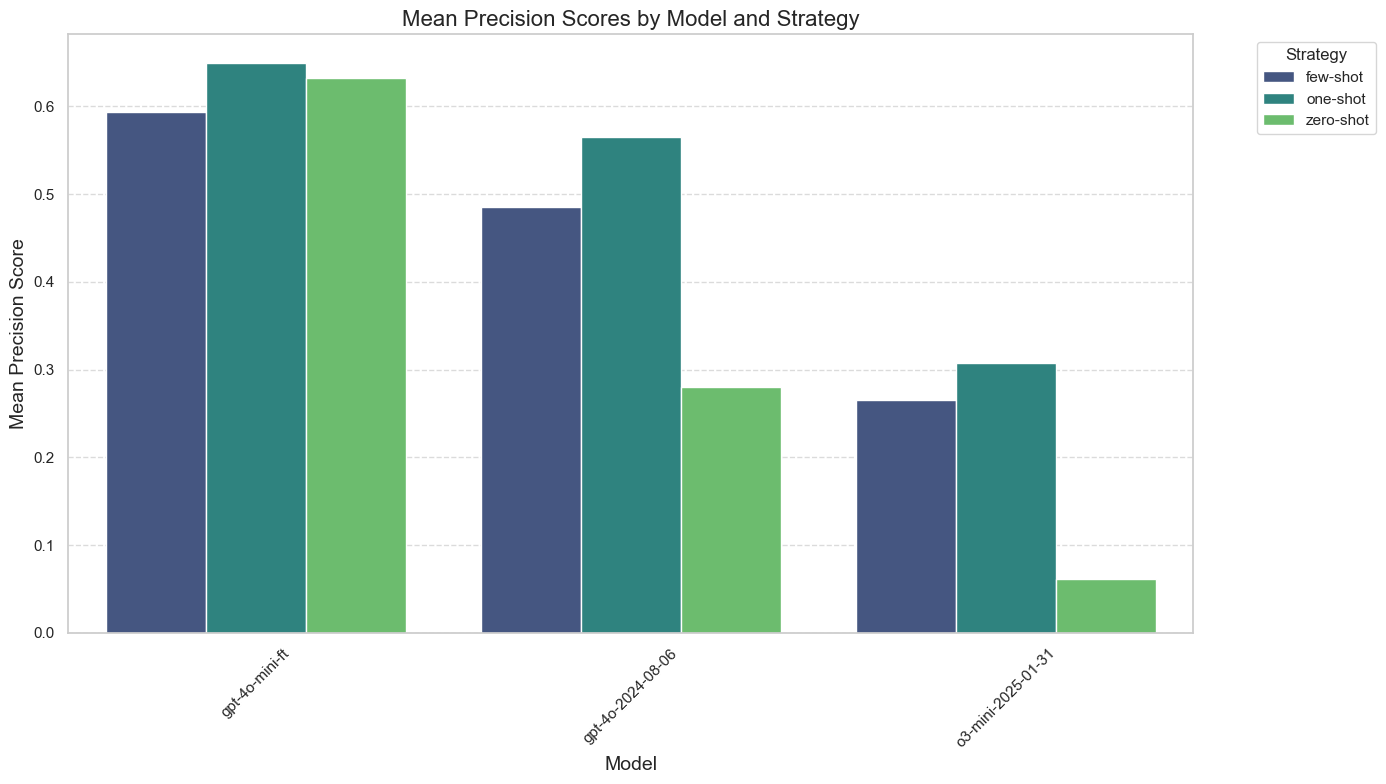

In [9]:
# Create a grouped bar chart of Precision scores by model and strategy
# Reorder strategies for plotting: zero-shot, one-shot, few-shot
strategy_order = ['zero-shot', 'one-shot', 'few-shot']

precision_by_model_strategy['strategy'] = pd.Categorical(precision_by_model_strategy['strategy'], categories=strategy_order, ordered=True)

plt.figure(figsize=(14, 8))
sns.barplot(
    x='model',
    y='Mean Precision',
    hue='strategy',
    data=precision_by_model_strategy,
    hue_order=strategy_order[::-1],  # right to left: zero-shot, one-shot, few-shot
    palette='viridis'
)
plt.title('Mean Precision Scores by Model and Strategy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Precision Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Compare F1 Score by Model and Strategy

We'll analyze how F1 scores vary across different models and strategies.

In [10]:
# --- Create a filtered DataFrame specifically for F1 analysis ---
print(f"Original DataFrame size for F1 analysis: {len(df_1)} rows")
df_f1_filtered = df_1[df_1['f1_score'] > 0].copy()
rows_removed_f1 = len(df_1) - len(df_f1_filtered)
print(f"Removed {rows_removed_f1} rows with zero F1 score for F1 analysis. Using {len(df_f1_filtered)} rows.")
# --- End of filtering ---

Original DataFrame size for F1 analysis: 756 rows
Removed 412 rows with zero F1 score for F1 analysis. Using 344 rows.


In [11]:
#print all columns of the filtered dataframe that include the word 'f1'
print("Columns in the filtered DataFrame that include 'f1':")
f1_columns = [col for col in df_f1_filtered.columns if 'f1' in col]
print(f1_columns)

Columns in the filtered DataFrame that include 'f1':
['f1_score', 'f1_score_core', 'f1_score_policy_char', 'f1_score_compliance_char', 'f1_score_actor', 'f1_score_other', 'f1_score_time', 'property_f1_score', 'class_f1_score', 'entity_f1_score', 'rel_contains_instrument_f1_score_contains_instrument', 'rel_contains_objective_f1_score_contains_objective', 'rel_contains_monitoring_form_f1_score_contains_monitoring_form', 'rel_contains_sanctioning_form_f1_score_contains_sanctioning_form', 'rel_addresses_f1_score_addresses']


In [12]:
# Calculate mean F1 scores grouped by model and strategy using the filtered DataFrame
f1_by_model_strategy = df_f1_filtered.groupby(['model', 'strategy'])['f1_score'].agg(['mean', 'std', 'count']).reset_index() # Changed df to df_f1_filtered
f1_by_model_strategy.columns = ['Model', 'Strategy', 'Mean F1', 'Std Dev', 'Count']
f1_by_model_strategy = f1_by_model_strategy.sort_values('Mean F1', ascending=False)

print("F1 Scores by Model and Strategy (excluding zero scores):") # Updated print message
f1_by_model_strategy

F1 Scores by Model and Strategy (excluding zero scores):


,Model,Strategy,Mean F1,Std Dev,Count
5,gpt-4o-mini-ft,zero-shot,0.714206,0.115891,42
4,gpt-4o-mini-ft,one-shot,0.701880,0.125184,42
3,gpt-4o-mini-ft,few-shot,0.649447,0.132079,42
1,gpt-4o-2024-08-06,one-shot,0.582375,0.127228,42
0,gpt-4o-2024-08-06,few-shot,0.530076,0.119350,42
7,o3-mini-2025-01-31,one-shot,0.384362,0.177675,37
6,o3-mini-2025-01-31,few-shot,0.355677,0.148809,36
2,gpt-4o-2024-08-06,zero-shot,0.274334,0.123823,39
8,o3-mini-2025-01-31,zero-shot,0.084469,0.027940,22


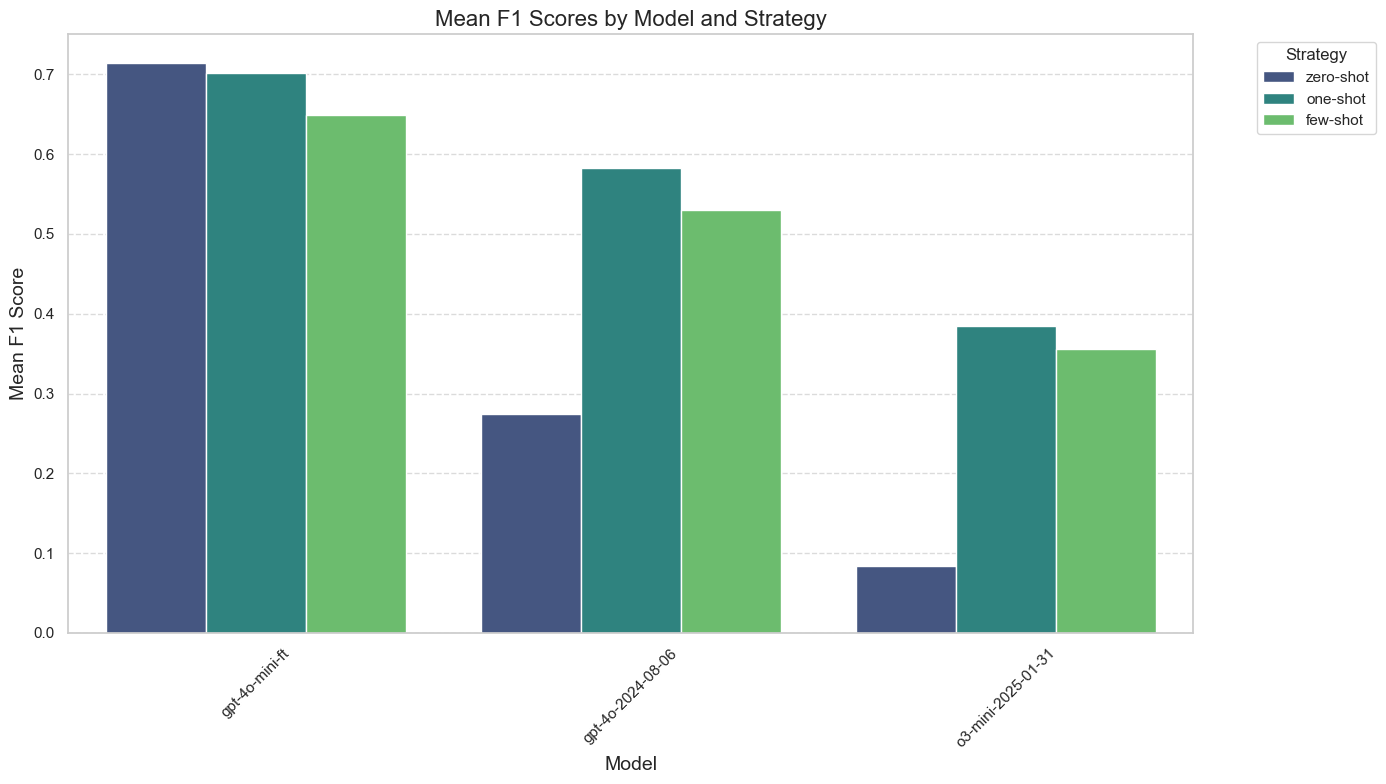

In [13]:
# Create a grouped bar chart of F1 scores by model and strategy
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Mean F1', hue='Strategy', data=f1_by_model_strategy, palette='viridis')
plt.title('Mean F1 Scores by Model and Strategy', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean F1 Score', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
print(f1_by_model_strategy.columns)
print(precision_by_model_strategy.columns)
print(recall_by_model_strategy.columns)

Index(['Model', 'Strategy', 'Mean F1', 'Std Dev', 'Count'], dtype='object')
Index(['model', 'strategy', 'Mean Precision', 'Std Dev', 'Count'], dtype='object')
Index(['model', 'strategy', 'Mean Recall', 'Std Dev', 'Count'], dtype='object')


In [15]:
# In the cell with id '5077eaf3'

# --- Prepare each DF for merge by selecting only the 'Model','Strategy' and mean columns ---
# F1 df: keep only Model, Strategy, Mean F1
f1_df = f1_by_model_strategy[['Model','Strategy','Mean F1']]

# Precision df: rename columns then keep only Model, Strategy, Mean Precision
precision_df = (
    precision_by_model_strategy
    .rename(columns={'model':'Model','strategy':'Strategy','Mean Precision':'Mean Precision'})
    [['Model','Strategy','Mean Precision']]
)

# Recall df: rename columns then keep only Model, Strategy, Mean Recall
recall_df = (
    recall_by_model_strategy
    .rename(columns={'model':'Model','strategy':'Strategy','Mean Recall':'Mean Recall'})
    [['Model','Strategy','Mean Recall']]
)

# --- Merge on ['Model','Strategy'] to get only the mean scores ---
df_PRF_overview = (
    f1_df
    .merge(precision_df, on=['Model','Strategy'], how='inner')
    .merge(recall_df,    on=['Model','Strategy'], how='inner')
)

# df_PRF_overview now has only:
# ['Model','Strategy','Mean F1','Mean Precision','Mean Recall']
print(df_PRF_overview)

                Model   Strategy   Mean F1  Mean Precision  Mean Recall
0      gpt-4o-mini-ft  zero-shot  0.714206        0.632725     0.836597
1      gpt-4o-mini-ft   one-shot  0.701880        0.649657     0.778811
2      gpt-4o-mini-ft   few-shot  0.649447        0.593171     0.733284
3   gpt-4o-2024-08-06   one-shot  0.582375        0.564723     0.613813
4   gpt-4o-2024-08-06   few-shot  0.530076        0.485753     0.604099
5  o3-mini-2025-01-31   one-shot  0.384362        0.307808     0.571898
6  o3-mini-2025-01-31   few-shot  0.355677        0.264932     0.580289
7   gpt-4o-2024-08-06  zero-shot  0.274334        0.280160     0.293212
8  o3-mini-2025-01-31  zero-shot  0.084469        0.061525     0.183922


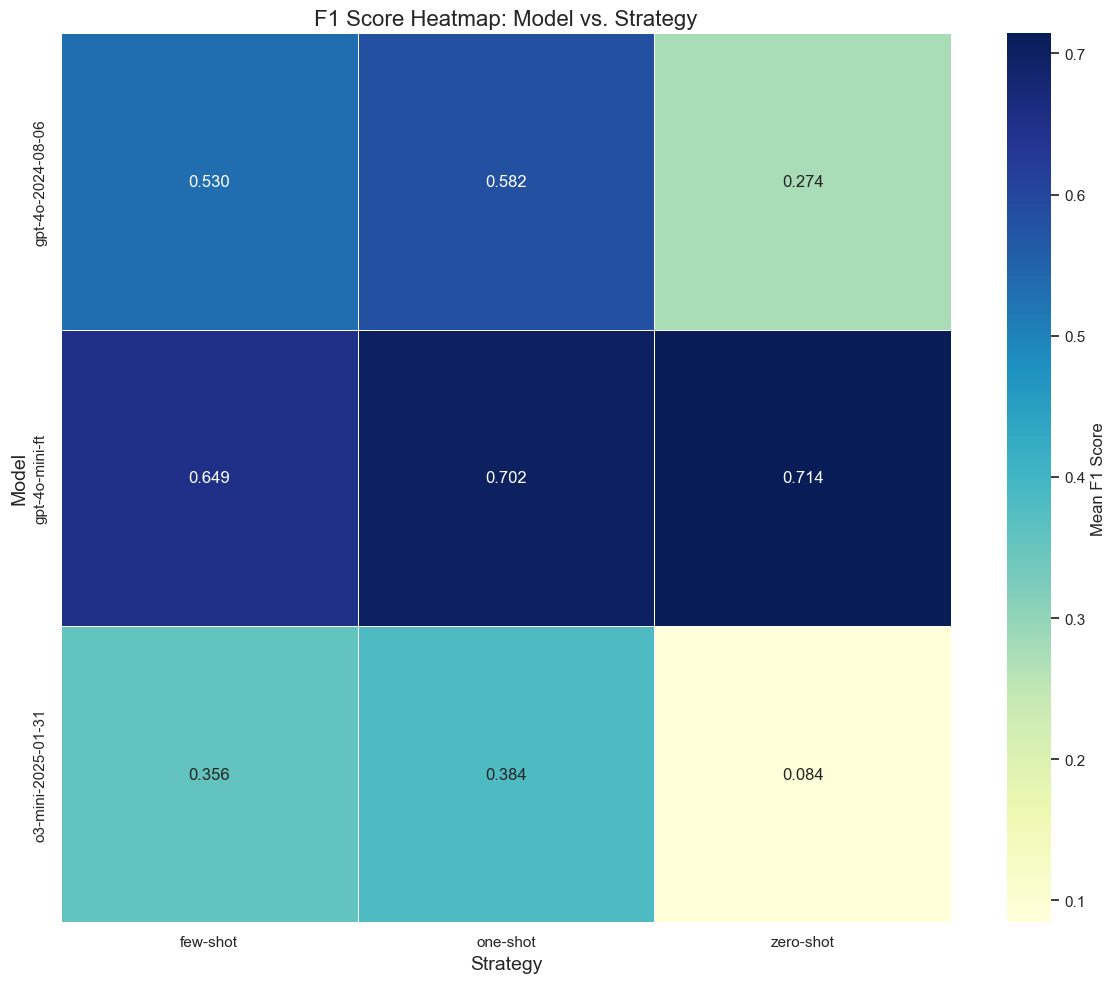

In [16]:
# Create a heatmap to visualize F1 scores
pivot_f1 = f1_by_model_strategy.pivot_table(values='Mean F1', index='Model', columns='Strategy', aggfunc='mean')

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_f1, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5, cbar_kws={'label': 'Mean F1 Score'})
plt.title('F1 Score Heatmap: Model vs. Strategy', fontsize=16)
plt.xlabel('Strategy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.tight_layout()
plt.show()

## Compare F1 Score by Model and Triplet type
We'll analyze how F1 scores vary across different models and triplet types.

Filtered data to 344 rows with overall f1_score > 0.

Determining best strategy per model based on mean overall F1 score...
Best strategy per model:
- gpt-4o-2024-08-06: one-shot
- gpt-4o-mini-ft: zero-shot
- o3-mini-2025-01-31: one-shot

Filtered data to 121 rows corresponding to the best strategy for each model.

Renamed models for plotting: {'gpt-4o-mini-ft': 'GPT-4o-mini-ft', 'gpt-4o-2024-08-06': 'GPT-4o', 'o3-mini-2025-01-31': 'o3-mini'}
Updated best_strategy_map with new model names: {'GPT-4o': 'one-shot', 'GPT-4o-mini-ft': 'zero-shot', 'o3-mini': 'one-shot'}

Mean F1 Scores per Triplet Type (using best strategy per model, excluding zero scores per type):
             Model   Strategy                Triplet Type  Mean F1  Std Dev  \
0   GPT-4o-mini-ft  zero-shot              Core Structure    1.000    0.000   
1   GPT-4o-mini-ft  zero-shot      Policy Characteristics    0.750    0.195   
2   GPT-4o-mini-ft  zero-shot  Compliance Characteristics    0.917    0.136   
3   GPT-4o-min

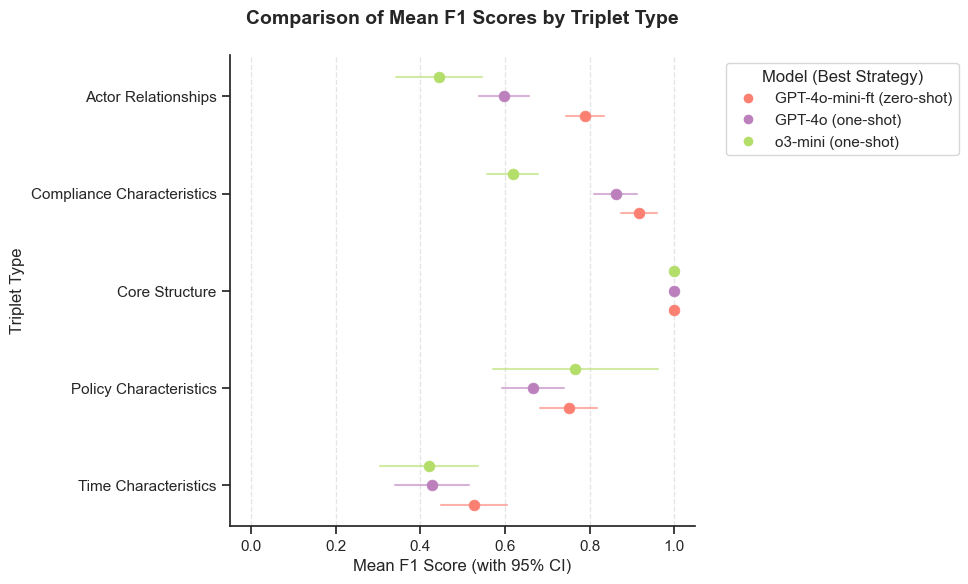

In [43]:
import plotly.express as px

OUTPUT_DIR = Path('figures') # Define output directory relative to notebook
OUTPUT_DIR.mkdir(exist_ok=True) # Create output directory if it doesn't exist

# --- Styling (Mimicking ground_truth_analysis notebook) ---
# Using a style similar to 'apa' or 'science' from the notebook
sns.set_style("ticks") # Use 'ticks' which is common for science/apa
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] # Or 'Times New Roman' for APA
# Reset figsize for this plot if needed, or use notebook default
# plt.rcParams['figure.figsize'] = (12, 8) # Default figure size

# Helper to parse Plotly colors if needed (though we'll use seaborn palettes)
def parse_plotly_color(c):
    if isinstance(c, str) and c.startswith('rgb'):
        nums_str = re.findall(r'\d+', c)
        if len(nums_str) == 3:
            nums = list(map(int, nums_str))
            return tuple(n/255 for n in nums)
        else:
            # print(f"Warning: Could not parse RGB string '{c}'. Using default color.")
            return (0.5, 0.5, 0.5) # Default grey
    # Handle hex codes directly
    elif isinstance(c, str) and c.startswith('#') and len(c) == 7:
        return c
    # Fallback for unexpected formats
    return c if isinstance(c, (tuple, str)) else (0.5, 0.5, 0.5)

# --- Define Triplet F1 Columns and Nice Names ---
# Make sure these column names exactly match your CSV file
triplet_f1_cols_map = {
    'f1_score_core': 'Core Structure',
    'f1_score_policy_char': 'Policy Characteristics',
    'f1_score_compliance_char': 'Compliance Characteristics',
    'f1_score_actor': 'Actor Relationships',
    'f1_score_time': 'Time Characteristics',
    'f1_score_other': 'Other Triples'
}
triplet_f1_cols = list(triplet_f1_cols_map.keys())

# Check if columns exist in the dataframe
missing_cols = [col for col in triplet_f1_cols if col not in df_1.columns]
if missing_cols:
    print(f"Warning: The following triplet F1 columns are missing from the DataFrame: {missing_cols}")
    # Remove missing columns from our map and list
    triplet_f1_cols_map = {k: v for k, v in triplet_f1_cols_map.items() if k not in missing_cols}
    triplet_f1_cols = list(triplet_f1_cols_map.keys())
    if not triplet_f1_cols:
        print("Error: No triplet F1 score columns found. Cannot proceed.")
        # Optionally exit or raise an error
        # exit()


# --- 2. Filter Data (Overall F1 > 0) ---
df_filtered = df_1[df_1['f1_score'] > 0].copy()
print(f"Filtered data to {len(df_filtered)} rows with overall f1_score > 0.")

# --- 3. Determine Best Strategy per Model (based on mean overall F1) ---
print("\nDetermining best strategy per model based on mean overall F1 score...")
# Calculate mean overall F1 for each model-strategy pair
mean_overall_f1 = df_filtered.groupby(['model', 'strategy'])['f1_score'].mean().reset_index()

# Find the index of the max mean F1 for each model
# Handle cases where a model might not have any scores > 0
if not mean_overall_f1.empty:
    best_strategy_idx = mean_overall_f1.loc[mean_overall_f1.groupby('model')['f1_score'].idxmax()]
    # Create a mapping from model to its best strategy
    best_strategy_map = dict(zip(best_strategy_idx['model'], best_strategy_idx['strategy']))
else:
    best_strategy_map = {}
    print("Warning: No data found after filtering for f1_score > 0. Cannot determine best strategies.")


print("Best strategy per model:")
if best_strategy_map:
    for model, strategy in best_strategy_map.items():
        print(f"- {model}: {strategy}")
else:
    print("  (No best strategies determined)")


# --- 4. Filter for Best Strategies ---
# Apply the mapping to filter the dataframe
if best_strategy_map:
    df_best = df_filtered[df_filtered.apply(lambda row: row['strategy'] == best_strategy_map.get(row['model']), axis=1)].copy()
    print(f"\nFiltered data to {len(df_best)} rows corresponding to the best strategy for each model.")
else:
    df_best = pd.DataFrame() # Empty dataframe if no best strategies
    print("\nNo data corresponding to best strategies.")

# --- 5. Calculate Mean Triplet Type F1 Scores (for best strategies) ---
results = []
if not df_best.empty:
    models_in_best_df = df_best['model'].unique()

    for model in models_in_best_df:
        model_data = df_best[df_best['model'] == model]
        best_strategy = best_strategy_map.get(model, 'N/A') # Get the best strategy for this model

        for f1_col, nice_name in triplet_f1_cols_map.items():
            if f1_col in model_data.columns:
                # Filter for non-zero scores *for this specific triplet type*
                valid_scores = model_data[model_data[f1_col] > 0][f1_col]
                count = len(valid_scores)
                if count > 0:
                    mean_f1 = valid_scores.mean()
                    std_f1 = valid_scores.std()
                    # Calculate Standard Error (SE) for CI
                    se = std_f1 / np.sqrt(count) if count > 0 else 0
                    # Calculate 95% Confidence Interval (CI) using T-distribution for small samples?
                    # Using 1.96 (Z-score) is common for larger samples.
                    # from scipy import stats
                    # if count > 1:
                    #     t_crit = stats.t.ppf(1 - 0.025, count - 1)
                    #     ci_margin = t_crit * se
                    # else:
                    #     ci_margin = 1.96 * se # Fallback for count=1
                    ci_margin = 1.96 * se # Using Z-score approximation
                    lower_ci = mean_f1 - ci_margin
                    upper_ci = mean_f1 + ci_margin

                    results.append({
                        'Model': model,
                        'Strategy': best_strategy, # Store the strategy used
                        'Triplet Type': nice_name,
                        'Mean F1': mean_f1,
                        'Std Dev': std_f1,
                        'Count': count,
                        'Lower CI': lower_ci,
                        'Upper CI': upper_ci
                    })
                else:
                     results.append({
                        'Model': model,
                        'Strategy': best_strategy,
                        'Triplet Type': nice_name,
                        'Mean F1': 0, # Assign 0 if no valid scores > 0
                        'Std Dev': 0,
                        'Count': 0,
                        'Lower CI': 0,
                        'Upper CI': 0
                    })
            # else: # Warning already printed during column check
            #     print(f"Warning: Column {f1_col} not found in the data for model {model}.")

# Create DataFrame from results
f1_type_comparison_df = pd.DataFrame(results)

# --- Filter out 'Other Triples' before plotting ---
f1_type_comparison_df_filtered = f1_type_comparison_df[f1_type_comparison_df['Triplet Type'] != 'Other Triples'].copy()

# --- Rename Models ---
# Define the mapping for renaming models.
# IMPORTANT: Ensure the keys exactly match the model names currently in the DataFrame.
model_rename_map = {
    'o3-mini-2025-01-31': 'o3-mini', # Renaming Claude Opus to o3-mini as requested
    'gpt-4o-2024-08-06': 'GPT-4o',
    'gpt-4o-mini-ft': 'GPT-4o-mini-ft'
    # Add other mappings if necessary
}
# Apply the renaming
original_models = f1_type_comparison_df_filtered['Model'].unique()
f1_type_comparison_df_filtered['Model'] = f1_type_comparison_df_filtered['Model'].replace(model_rename_map)
renamed_models = f1_type_comparison_df_filtered['Model'].unique()
print(f"\nRenamed models for plotting: {dict(zip(original_models, renamed_models))}")
# Update the best_strategy_map keys to use the new names
best_strategy_map = {model_rename_map.get(k, k): v for k, v in best_strategy_map.items()}
print("Updated best_strategy_map with new model names:", best_strategy_map)

if not f1_type_comparison_df_filtered.empty:
    print("\nMean F1 Scores per Triplet Type (using best strategy per model, excluding zero scores per type):")
    print(f1_type_comparison_df_filtered.round(3))
else:
    print("\nNo results calculated for triplet type F1 scores.")


# --- 6. Visualize (Forest Plot Style) ---
if not f1_type_comparison_df_filtered.empty:
    print("\nGenerating Forest Plot...")

    # Sort data for consistent plotting order (optional, but good practice)
    f1_type_comparison_df_filtered = f1_type_comparison_df_filtered.sort_values(by=['Triplet Type', 'Mean F1'], ascending=[True, False])

    # Get unique models and triplet types for plotting setup
    models_to_plot = f1_type_comparison_df_filtered['Model'].unique()
    triplet_types_to_plot = f1_type_comparison_df_filtered['Triplet Type'].unique()
    n_models = len(models_to_plot)
    n_types = len(triplet_types_to_plot)

    def parse_plotly_color(c):
        if c.startswith('rgb'):
            nums = re.findall(r'\d+', c)
            return tuple(int(n)/255 for n in nums)
        return c
    
    set3_colors_raw = px.colors.qualitative.Set3

    # --- Select specific colors from Set3 ---
    selected_indices = [3, 9, 6] # Change these indices as needed
    if max(selected_indices) >= len(set3_colors_raw):
        print(f"Warning: Selected index {max(selected_indices)} is out of bounds for Set3 (length {len(set3_colors_raw)}). Using available colors.")
        selected_indices = [i for i in selected_indices if i < len(set3_colors_raw)]
        if not selected_indices: # Handle case where all indices were invalid
             selected_indices = [0, 1, 2] # Fallback to first 3
             print("Falling back to first 3 colors.")

    selected_colors_raw = [set3_colors_raw[i] for i in selected_indices]
    num_selected_colors = len(selected_colors_raw)
    colors = [parse_plotly_color(selected_colors_raw[i % num_selected_colors]) for i in range(n_models)]
    model_color_map = dict(zip(models_to_plot, colors))

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, max(6, n_types * 0.9 + 1))) # Adjust height based on number of types, ensure min height

    # Define y-positions for each triplet type
    y_positions = {triplet_type: i for i, triplet_type in enumerate(reversed(triplet_types_to_plot))} # Reverse for top-to-bottom

    # Define small vertical offsets for models within each type to avoid overlap
    offsets = np.linspace(-0.2, 0.2, n_models) if n_models > 1 else [0]
    model_offset_map = dict(zip(models_to_plot, offsets))

    # Plot points and error bars for each model and triplet type
    plotted_labels = set() # To ensure legend labels are unique
    for i, row in f1_type_comparison_df_filtered.iterrows():
        model = row['Model']
        triplet_type = row['Triplet Type']
        mean_f1 = row['Mean F1']
        lower_ci = row['Lower CI']
        upper_ci = row['Upper CI']
        y_pos = y_positions[triplet_type] + model_offset_map[model]
        color = model_color_map[model]

        # Plot error bar line
        ax.plot([lower_ci, upper_ci], [y_pos, y_pos], '-', color=color, alpha=0.6, lw=1.5)
        # Plot mean F1 point
        label = model if model not in plotted_labels else ""
        ax.scatter(mean_f1, y_pos, s=60, color=color, zorder=3, linewidth=0.5, label=label)
        if label:
            plotted_labels.add(model)


    # Customize the plot
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(list(reversed(triplet_types_to_plot))) # Match reversed y_positions
    ax.set_xlabel('Mean F1 Score (with 95% CI)', fontsize=12)
    ax.set_ylabel('Triplet Type', fontsize=12)
    ax.set_title('Comparison of Mean F1 Scores by Triplet Type', fontsize=14, y=1.05, fontweight='bold')

    # Add a vertical line at F1=0.5 for reference (optional)
    # ax.axvline(x=0.5, color='grey', linestyle='--', alpha=0.7, label='F1 = 0.5')

    # Improve appearance
    ax.grid(axis='x', linestyle='--', alpha=0.5) # Subtle grid on x-axis only
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(left=-0.05, right=1.05) # Ensure CI lower bound is visible if near 0 and upper bound if near 1

    # Create a legend for models
    handles, labels = ax.get_legend_handles_labels()
    # Create unique legend entries based on plotted labels
    unique_handles_labels = {label: handle for handle, label in zip(handles, labels)}

    # Add strategy info to legend labels
    legend_elements = []
    for model, handle in unique_handles_labels.items():
        strategy = best_strategy_map.get(model, 'N/A')
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=model_color_map[model],
                                          markersize=8, label=f'{model} ({strategy})'))

    ax.legend(handles=legend_elements, title="Model (Best Strategy)", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, framealpha=0.9, edgecolor='lightgray')

    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to make space for legend

    plt.show()

else:
    print("\nSkipping plot generation as no data was available.")

# Reset styling to notebook defaults if desired (optional)
# plt.style.use('ggplot')
# sns.set_theme(style="whitegrid")
# plt.rcParams['font.family'] = plt.rcParamsDefault['font.family']
# plt.rcParams['figure.figsize'] = (12, 8) # Reset to notebook default

Filtered data to 344 rows with overall f1_score > 0.

Determining best strategy per model based on mean overall F1 score...
Best strategy per model:
- gpt-4o-2024-08-06: one-shot
- gpt-4o-mini-ft: zero-shot
- o3-mini-2025-01-31: one-shot

Filtered data to 121 rows corresponding to the best strategy for each model.

Renamed models for plotting: {'gpt-4o-mini-ft': 'GPT-4o-mini-ft', 'gpt-4o-2024-08-06': 'GPT-4o', 'o3-mini-2025-01-31': 'o3-mini'}
Updated best_strategy_map with new model names: {'GPT-4o': 'one-shot', 'GPT-4o-mini-ft': 'zero-shot', 'o3-mini': 'one-shot'}

Mean F1 Scores per Triplet Type (using best strategy per model, excluding zero scores per type):
             Model   Strategy                Triplet Type  Mean F1  Std Dev  \
0   GPT-4o-mini-ft  zero-shot              Core Structure    1.000    0.000   
1   GPT-4o-mini-ft  zero-shot      Policy Characteristics    0.750    0.195   
2   GPT-4o-mini-ft  zero-shot  Compliance Characteristics    0.917    0.136   
3   GPT-4o-min

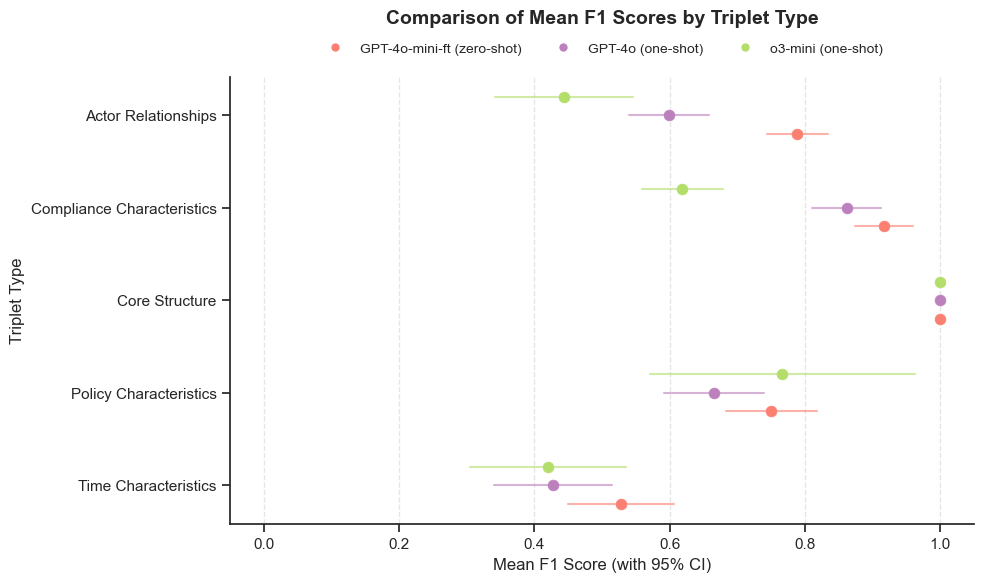

In [47]:
import plotly.express as px

OUTPUT_DIR = Path('figures') # Define output directory relative to notebook
OUTPUT_DIR.mkdir(exist_ok=True) # Create output directory if it doesn't exist

# --- Styling (Mimicking ground_truth_analysis notebook) ---
# Using a style similar to 'apa' or 'science' from the notebook
sns.set_style("ticks") # Use 'ticks' which is common for science/apa
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] # Or 'Times New Roman' for APA
# Reset figsize for this plot if needed, or use notebook default
# plt.rcParams['figure.figsize'] = (12, 8) # Default figure size

# Helper to parse Plotly colors if needed (though we'll use seaborn palettes)
def parse_plotly_color(c):
    if isinstance(c, str) and c.startswith('rgb'):
        nums_str = re.findall(r'\d+', c)
        if len(nums_str) == 3:
            nums = list(map(int, nums_str))
            return tuple(n/255 for n in nums)
        else:
            # print(f"Warning: Could not parse RGB string '{c}'. Using default color.")
            return (0.5, 0.5, 0.5) # Default grey
    # Handle hex codes directly
    elif isinstance(c, str) and c.startswith('#') and len(c) == 7:
        return c
    # Fallback for unexpected formats
    return c if isinstance(c, (tuple, str)) else (0.5, 0.5, 0.5)

# --- Define Triplet F1 Columns and Nice Names ---
# Make sure these column names exactly match your CSV file
triplet_f1_cols_map = {
    'f1_score_core': 'Core Structure',
    'f1_score_policy_char': 'Policy Characteristics',
    'f1_score_compliance_char': 'Compliance Characteristics',
    'f1_score_actor': 'Actor Relationships',
    'f1_score_time': 'Time Characteristics',
    'f1_score_other': 'Other Triples'
}
triplet_f1_cols = list(triplet_f1_cols_map.keys())

# Check if columns exist in the dataframe
missing_cols = [col for col in triplet_f1_cols if col not in df_1.columns]
if missing_cols:
    print(f"Warning: The following triplet F1 columns are missing from the DataFrame: {missing_cols}")
    # Remove missing columns from our map and list
    triplet_f1_cols_map = {k: v for k, v in triplet_f1_cols_map.items() if k not in missing_cols}
    triplet_f1_cols = list(triplet_f1_cols_map.keys())
    if not triplet_f1_cols:
        print("Error: No triplet F1 score columns found. Cannot proceed.")
        # Optionally exit or raise an error
        # exit()


# --- 2. Filter Data (Overall F1 > 0) ---
df_filtered = df_1[df_1['f1_score'] > 0].copy()
print(f"Filtered data to {len(df_filtered)} rows with overall f1_score > 0.")

# --- 3. Determine Best Strategy per Model (based on mean overall F1) ---
print("\nDetermining best strategy per model based on mean overall F1 score...")
# Calculate mean overall F1 for each model-strategy pair
mean_overall_f1 = df_filtered.groupby(['model', 'strategy'])['f1_score'].mean().reset_index()

# Find the index of the max mean F1 for each model
# Handle cases where a model might not have any scores > 0
if not mean_overall_f1.empty:
    best_strategy_idx = mean_overall_f1.loc[mean_overall_f1.groupby('model')['f1_score'].idxmax()]
    # Create a mapping from model to its best strategy
    best_strategy_map = dict(zip(best_strategy_idx['model'], best_strategy_idx['strategy']))
else:
    best_strategy_map = {}
    print("Warning: No data found after filtering for f1_score > 0. Cannot determine best strategies.")


print("Best strategy per model:")
if best_strategy_map:
    for model, strategy in best_strategy_map.items():
        print(f"- {model}: {strategy}")
else:
    print("  (No best strategies determined)")


# --- 4. Filter for Best Strategies ---
# Apply the mapping to filter the dataframe
if best_strategy_map:
    df_best = df_filtered[df_filtered.apply(lambda row: row['strategy'] == best_strategy_map.get(row['model']), axis=1)].copy()
    print(f"\nFiltered data to {len(df_best)} rows corresponding to the best strategy for each model.")
else:
    df_best = pd.DataFrame() # Empty dataframe if no best strategies
    print("\nNo data corresponding to best strategies.")

# --- 5. Calculate Mean Triplet Type F1 Scores (for best strategies) ---
results = []
if not df_best.empty:
    models_in_best_df = df_best['model'].unique()

    for model in models_in_best_df:
        model_data = df_best[df_best['model'] == model]
        best_strategy = best_strategy_map.get(model, 'N/A') # Get the best strategy for this model

        for f1_col, nice_name in triplet_f1_cols_map.items():
            if f1_col in model_data.columns:
                # Filter for non-zero scores *for this specific triplet type*
                valid_scores = model_data[model_data[f1_col] > 0][f1_col]
                count = len(valid_scores)
                if count > 0:
                    mean_f1 = valid_scores.mean()
                    std_f1 = valid_scores.std()
                    # Calculate Standard Error (SE) for CI
                    se = std_f1 / np.sqrt(count) if count > 0 else 0
                    # Calculate 95% Confidence Interval (CI) using T-distribution for small samples?
                    # Using 1.96 (Z-score) is common for larger samples.
                    # from scipy import stats
                    # if count > 1:
                    #     t_crit = stats.t.ppf(1 - 0.025, count - 1)
                    #     ci_margin = t_crit * se
                    # else:
                    #     ci_margin = 1.96 * se # Fallback for count=1
                    ci_margin = 1.96 * se # Using Z-score approximation
                    lower_ci = mean_f1 - ci_margin
                    upper_ci = mean_f1 + ci_margin

                    results.append({
                        'Model': model,
                        'Strategy': best_strategy, # Store the strategy used
                        'Triplet Type': nice_name,
                        'Mean F1': mean_f1,
                        'Std Dev': std_f1,
                        'Count': count,
                        'Lower CI': lower_ci,
                        'Upper CI': upper_ci
                    })
                else:
                     results.append({
                        'Model': model,
                        'Strategy': best_strategy,
                        'Triplet Type': nice_name,
                        'Mean F1': 0, # Assign 0 if no valid scores > 0
                        'Std Dev': 0,
                        'Count': 0,
                        'Lower CI': 0,
                        'Upper CI': 0
                    })
            # else: # Warning already printed during column check
            #     print(f"Warning: Column {f1_col} not found in the data for model {model}.")

# Create DataFrame from results
f1_type_comparison_df = pd.DataFrame(results)

# --- Filter out 'Other Triples' before plotting ---
f1_type_comparison_df_filtered = f1_type_comparison_df[f1_type_comparison_df['Triplet Type'] != 'Other Triples'].copy()

# --- Rename Models ---
# Define the mapping for renaming models.
# IMPORTANT: Ensure the keys exactly match the model names currently in the DataFrame.
model_rename_map = {
    'o3-mini-2025-01-31': 'o3-mini', # Renaming Claude Opus to o3-mini as requested
    'gpt-4o-2024-08-06': 'GPT-4o',
    'gpt-4o-mini-ft': 'GPT-4o-mini-ft'
    # Add other mappings if necessary
}
# Apply the renaming
original_models = f1_type_comparison_df_filtered['Model'].unique()
f1_type_comparison_df_filtered['Model'] = f1_type_comparison_df_filtered['Model'].replace(model_rename_map)
renamed_models = f1_type_comparison_df_filtered['Model'].unique()
print(f"\nRenamed models for plotting: {dict(zip(original_models, renamed_models))}")
# Update the best_strategy_map keys to use the new names
best_strategy_map = {model_rename_map.get(k, k): v for k, v in best_strategy_map.items()}
print("Updated best_strategy_map with new model names:", best_strategy_map)

if not f1_type_comparison_df_filtered.empty:
    print("\nMean F1 Scores per Triplet Type (using best strategy per model, excluding zero scores per type):")
    print(f1_type_comparison_df_filtered.round(3))
else:
    print("\nNo results calculated for triplet type F1 scores.")


# --- 6. Visualize (Forest Plot Style) ---
if not f1_type_comparison_df_filtered.empty:
    print("\nGenerating Forest Plot...")

    # Sort data for consistent plotting order (optional, but good practice)
    f1_type_comparison_df_filtered = f1_type_comparison_df_filtered.sort_values(by=['Triplet Type', 'Mean F1'], ascending=[True, False])

    # Get unique models and triplet types for plotting setup
    models_to_plot = f1_type_comparison_df_filtered['Model'].unique()
    triplet_types_to_plot = f1_type_comparison_df_filtered['Triplet Type'].unique()
    n_models = len(models_to_plot)
    n_types = len(triplet_types_to_plot)

    def parse_plotly_color(c):
        if c.startswith('rgb'):
            nums = re.findall(r'\d+', c)
            return tuple(int(n)/255 for n in nums)
        return c
    
    set3_colors_raw = px.colors.qualitative.Set3

    # --- Select specific colors from Set3 ---
    selected_indices = [3, 9, 6] # Change these indices as needed
    if max(selected_indices) >= len(set3_colors_raw):
        print(f"Warning: Selected index {max(selected_indices)} is out of bounds for Set3 (length {len(set3_colors_raw)}). Using available colors.")
        selected_indices = [i for i in selected_indices if i < len(set3_colors_raw)]
        if not selected_indices: # Handle case where all indices were invalid
             selected_indices = [0, 1, 2] # Fallback to first 3
             print("Falling back to first 3 colors.")

    selected_colors_raw = [set3_colors_raw[i] for i in selected_indices]
    num_selected_colors = len(selected_colors_raw)
    colors = [parse_plotly_color(selected_colors_raw[i % num_selected_colors]) for i in range(n_models)]
    model_color_map = dict(zip(models_to_plot, colors))

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, max(6, n_types * 0.8 + 1))) # Adjust height based on number of types, ensure min height

    # Define y-positions for each triplet type
    y_positions = {triplet_type: i for i, triplet_type in enumerate(reversed(triplet_types_to_plot))} # Reverse for top-to-bottom

    # Define small vertical offsets for models within each type to avoid overlap
    offsets = np.linspace(-0.2, 0.2, n_models) if n_models > 1 else [0]
    model_offset_map = dict(zip(models_to_plot, offsets))

    # Plot points and error bars for each model and triplet type
    plotted_labels = set() # To ensure legend labels are unique
    for i, row in f1_type_comparison_df_filtered.iterrows():
        model = row['Model']
        triplet_type = row['Triplet Type']
        mean_f1 = row['Mean F1']
        lower_ci = row['Lower CI']
        upper_ci = row['Upper CI']
        y_pos = y_positions[triplet_type] + model_offset_map[model]
        color = model_color_map[model]

        # Plot error bar line
        ax.plot([lower_ci, upper_ci], [y_pos, y_pos], '-', color=color, alpha=0.6, lw=1.5)
        # Plot mean F1 point
        label = model if model not in plotted_labels else ""
        ax.scatter(mean_f1, y_pos, s=60, color=color, zorder=3, linewidth=0.5, label=label)
        if label:
            plotted_labels.add(model)


    # Customize the plot
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels(list(reversed(triplet_types_to_plot))) # Match reversed y_positions
    ax.set_xlabel('Mean F1 Score (with 95% CI)', fontsize=12)
    ax.set_ylabel('Triplet Type', fontsize=12)
    ax.set_title('Comparison of Mean F1 Scores by Triplet Type', fontsize=14, y=1.1, fontweight='bold')

    # Add a vertical line at F1=0.5 for reference (optional)
    # ax.axvline(x=0.5, color='grey', linestyle='--', alpha=0.7, label='F1 = 0.5')

    # Improve appearance
    ax.grid(axis='x', linestyle='--', alpha=0.5) # Subtle grid on x-axis only
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(left=-0.05, right=1.05) # Ensure CI lower bound is visible if near 0 and upper bound if near 1

    # Create a legend for models
    handles, labels = ax.get_legend_handles_labels()
    # Create unique legend entries based on plotted labels
    unique_handles_labels = {label: handle for handle, label in zip(handles, labels)}

    # Add strategy info to legend labels
    legend_elements = []
    for model, handle in unique_handles_labels.items():
        strategy = best_strategy_map.get(model, 'N/A')
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=model_color_map[model],
                                          markersize=7, label=f'{model} ({strategy})'))

    # --- Modified Legend ---
    # Place legend below the plot, horizontally, with multiple columns
    # Adjust ncol based on the number of models to make it fit well
    num_models = len(unique_handles_labels)
    legend_cols = min(num_models, 3) # Adjust max columns (e.g., 3 or 4) as needed

    ax.legend(handles=legend_elements, 
                # title="Model (Best Strategy)", # Removed title
                loc='lower center', 
                bbox_to_anchor=(0.5, 1.02), # Position below the x-axis
                ncol=legend_cols,           # Arrange in columns
                frameon=False,              # Remove legend frame
                fontsize='small')           # Use smaller font

    # Adjust layout to prevent legend overlap
    plt.tight_layout() # Adjust bottom margin (0.05) if needed

    plt.show()

else:
    print("\nSkipping plot generation as no data was available.")

## Analyze Learning Curves of Fine-Tuning

Fine-tuning data loaded successfully from experiment-1/fine-tuning-steps.csv


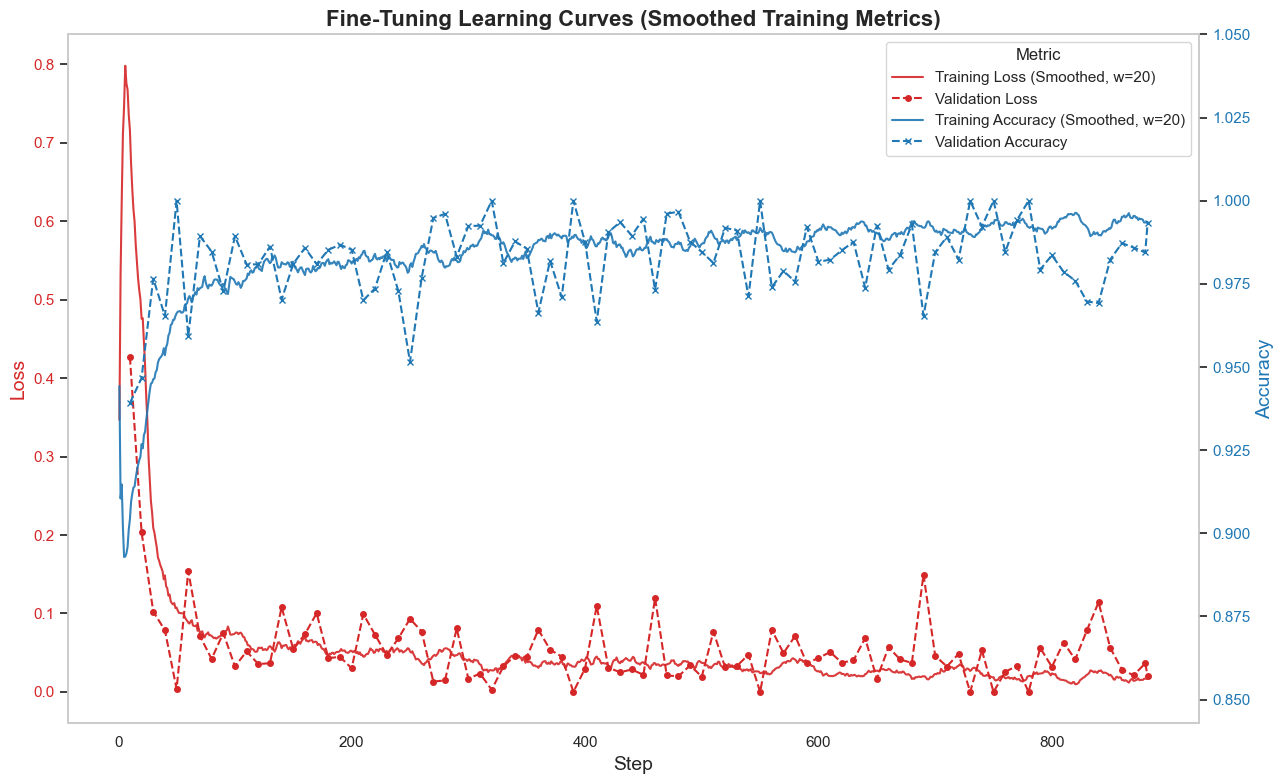

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Apply Consistent Styling (as used elsewhere in the notebook) ---
plt.style.use('ggplot')
sns.set_theme(style="whitegrid") # Seaborn theme might still add grid, we'll disable on axes
# plt.rcParams["figure.figsize"] = (12, 8) # Global setting

# --- Load the Fine-Tuning Data ---
ft_data_path = 'experiment-1/fine-tuning-steps.csv'
try:
    ft_df = pd.read_csv(ft_data_path)
    print(f"Fine-tuning data loaded successfully from {ft_data_path}")

    # --- Apply Smoothing (Rolling Average) ---
    smoothing_window = 20 # Adjust window size as needed (e.g., 10, 20)
    ft_df['train_loss_smoothed'] = ft_df['train_loss'].rolling(window=smoothing_window, min_periods=1).mean()
    ft_df['train_accuracy_smoothed'] = ft_df['train_accuracy'].rolling(window=smoothing_window, min_periods=1).mean()

    # --- Plot Learning Curves ---

    # Create figure and axes for the plots - Increase width here
    fig, ax1 = plt.subplots(figsize=(13, 8)) # Explicitly set a wider figure size

    # Plot Smoothed Training Loss (Primary Y-axis - Left)
    color = 'tab:red'
    ax1.set_xlabel('Step', fontsize=14)
    ax1.set_ylabel('Loss', color=color, fontsize=14)
    # Plot smoothed training loss
    ax1.plot(ft_df['step'], ft_df['train_loss_smoothed'], color=color, label=f'Training Loss (Smoothed, w={smoothing_window})', alpha=0.9)
    # Plot Validation Loss (still raw points)
    val_loss_steps = ft_df.dropna(subset=['valid_loss'])
    ax1.plot(val_loss_steps['step'], val_loss_steps['valid_loss'], color=color, linestyle='--', marker='o', markersize=4, label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    # Remove grid lines for the primary y-axis
    ax1.grid(False) # Disable grid for ax1

    # Create a second Y-axis for Accuracy (Right)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color, fontsize=14)
    # Plot smoothed training accuracy
    ax2.plot(ft_df['step'], ft_df['train_accuracy_smoothed'], color=color, label=f'Training Accuracy (Smoothed, w={smoothing_window})', alpha=0.9)
    # Plot Validation Accuracy (still raw points)
    val_acc_steps = ft_df.dropna(subset=['valid_mean_token_accuracy'])
    ax2.plot(val_acc_steps['step'], val_acc_steps['valid_mean_token_accuracy'], color=color, linestyle='--', marker='x', markersize=5, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    # Ensure grid is also off for the secondary axis
    ax2.grid(False) # Disable grid for ax2

    # Set accuracy limits
    min_val_acc = val_acc_steps['valid_mean_token_accuracy'].min() if not val_acc_steps.empty else ft_df['train_accuracy_smoothed'].min()
    min_train_acc = ft_df['train_accuracy_smoothed'].min()
    ax2.set_ylim(min(min_train_acc, min_val_acc) - 0.05, 1.05)


    # Add Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', title='Metric')

    # Add Title and finalize layout
    plt.title('Fine-Tuning Learning Curves (Smoothed Training Metrics)', fontsize=16, fontweight='bold')
    fig.tight_layout()
    #plt.subplots_adjust(right=0.85)
    plt.show()

except FileNotFoundError:
    print(f"Error: Fine-tuning data file not found at {ft_data_path}")
except Exception as e:
    print(f"An error occurred: {e}")


# Experiment 2

In [19]:
print(df.columns.tolist())

['article_id', 'model', 'strategy', 'is_valid', 'syntax_errors', 'precision', 'recall', 'f1_score', 'true_positives', 'false_positives', 'false_negatives', 'tp_core', 'fp_core', 'fn_core', 'precision_core', 'recall_core', 'f1_score_core', 'tp_policy_char', 'fp_policy_char', 'fn_policy_char', 'precision_policy_char', 'recall_policy_char', 'f1_score_policy_char', 'tp_compliance_char', 'fp_compliance_char', 'fn_compliance_char', 'precision_compliance_char', 'recall_compliance_char', 'f1_score_compliance_char', 'tp_actor', 'fp_actor', 'fn_actor', 'precision_actor', 'recall_actor', 'f1_score_actor', 'tp_other', 'fp_other', 'fn_other', 'precision_other', 'recall_other', 'f1_score_other', 'tp_time', 'fp_time', 'fn_time', 'precision_time', 'recall_time', 'f1_score_time', 'property_precision', 'property_recall', 'property_f1_score', 'property_true_positives', 'property_false_positives', 'property_false_negatives', 'property_diversity', 'class_precision', 'class_recall', 'class_f1_score', 'class

In [20]:
print(df.describe())

       syntax_errors    precision       recall     f1_score  true_positives  \
count    1176.000000  1176.000000  1176.000000  1176.000000     1176.000000   
mean        0.145408     0.198126     0.268574     0.222277        3.634354   
std         0.352662     0.255191     0.331923     0.279645        4.810518   
min         0.000000     0.000000     0.000000     0.000000        0.000000   
25%         0.000000     0.000000     0.000000     0.000000        0.000000   
50%         0.000000     0.000000     0.000000     0.000000        0.000000   
75%         0.000000     0.413793     0.578947     0.474311        7.000000   
max         1.000000     1.000000     1.000000     0.952381       21.000000   

       false_positives  false_negatives      tp_core      fp_core  \
count      1176.000000      1176.000000  1176.000000  1176.000000   
mean         10.860544        10.606293     1.176871     1.085884   
std           9.091550        14.785062     1.382323     1.357822   
min         

In [21]:
df["model"].unique()

array(['gpt-4o-mini-ft', 'gpt-4o-2024-08-06', 'llama3.1:70b',
       'qwen2.5:32b', 'qwen2.5-coder:32b', 'o3-mini-2025-01-31'],
      dtype=object)

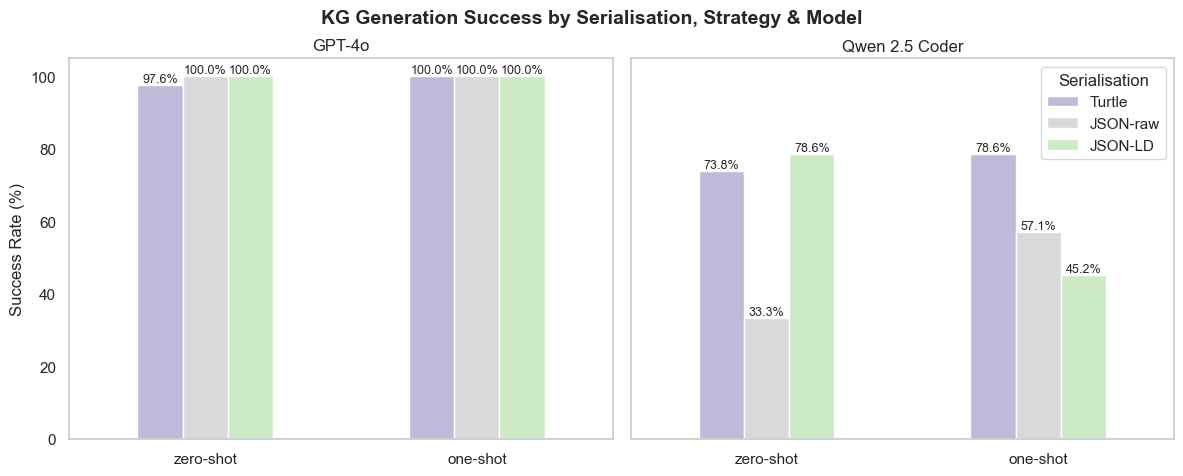

In [35]:
# 1) KG Generation Success across Serialization Methods ###
models_gen = ['gpt-4o-2024-08-06', 'qwen2.5-coder:32b']
strategies_gen = ['zero-shot', 'one-shot']
methods = ['experiment-1', 'experiment-2-raw', 'experiment-2-jsonld']

df_gen = df[
    df['model'].isin(models_gen) &
    df['strategy'].isin(strategies_gen) &
    df['experiment'].isin(methods)
]

# Compute success rate as percentage
gen_summary = (
    df_gen
    .groupby(['model','strategy','experiment'])['is_valid']
    .mean()
    .reset_index(name='Success Rate')
)
gen_summary['Success Rate'] *= 100

# Rename 'experiment'→'method'
gen_summary.rename(columns={'experiment':'method'}, inplace=True)

# Rename models for plotting
rename_map = {
    'gpt-4o-2024-08-06': 'GPT-4o',
    'qwen2.5-coder:32b': 'Qwen 2.5 Coder'
}
gen_summary['model'] = gen_summary['model'].replace(rename_map)
models_plot = list(rename_map.values())

# Prepare a color palette for methods
method_cols = [parse_plotly_color(px.colors.qualitative.Set3[i]) for i in [2, 8, 10]]
method_palette = dict(zip(methods, method_cols))

# Pivot‐and‐pandas‐plot approach
method_order = methods
palette = method_palette

fig, axes = plt.subplots(1, len(models_plot), figsize=(12, 5), sharey=True)
for ax, model in zip(axes, models_plot):
    sub = gen_summary[gen_summary['model'] == model]
    # pivot so each method is its own column
    pv = sub.pivot(index='strategy', columns='method', values='Success Rate')
    pv = pv.reindex(index=strategies_gen, columns=method_order)
    pv.plot(kind='bar', ax=ax, color=[palette[m] for m in pv.columns])
    ax.set_title(model)
    ax.set_ylim(0, 100)
    ax.set_xlabel('')
    if ax is axes[0]:
        ax.set_ylabel('Success Rate (%)')
    else:
        ax.set_ylabel('')
    # annotate bars
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.1f}%", 
                    (p.get_x() + p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9)
        
# --- Legend Modification START ---

# Define the mapping for legend labels
legend_rename_map = {
    'experiment-1': 'Turtle',
    'experiment-2-raw': 'JSON-raw',
    'experiment-2-jsonld': 'JSON-LD'
}

# Get handles and the original labels (which are the 'method' column values)
handles, labels = axes[-1].get_legend_handles_labels()

# Create the new list of labels using the mapping
# Apply mapping, defaulting to original label if somehow not found
new_labels = [legend_rename_map.get(lbl, lbl) for lbl in labels]

# --- Legend Modification END ---

# single legend and formatting
for ax in axes:
    # remove individual legends
    if ax.get_legend():
        ax.get_legend().remove()
    # remove gridlines
    ax.grid(False)
    # extend y-axis to fit 100%
    ax.set_ylim(0, 105)
    # make x‑labels horizontal
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    # # bold the subplot title
    # ax.set_title(ax.get_title(), fontweight='bold')
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, new_labels, title='Serialisation', loc='upper right', bbox_to_anchor=(0.985, 0.85))
plt.suptitle('KG Generation Success by Serialisation, Strategy & Model', y=0.95, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [23]:
### 2) F1 Performance Table & Visualization ###
# Compute mean overall F1 per model/strategy/method
df_f1 = df[
    df['model'].isin(models_gen) &
    df['strategy'].isin(strategies_gen) &
    df['experiment'].isin(methods)
]

f1_summary = (
    df_f1
    .groupby(['model','strategy','experiment'])['f1_score']
    .mean()
    .reset_index(name='Mean F1')
)

# Display a pivot table
f1_table = f1_summary.pivot_table(
    index=['model','strategy'], columns='experiment', values='Mean F1'
).round(3)
f1_table

experiment                   experiment-1  experiment-2-jsonld  \
model             strategy                                       
gpt-4o-2024-08-06 one-shot          0.582                0.576   
                  zero-shot         0.255                0.186   
qwen2.5-coder:32b one-shot          0.000                0.000   
                  zero-shot         0.000                0.000   

experiment                   experiment-2-raw  
model             strategy                     
gpt-4o-2024-08-06 one-shot              0.553  
                  zero-shot             0.268  
qwen2.5-coder:32b one-shot              0.000  
                  zero-shot             0.000

In [32]:
import plotly.express as px

# Get the Set3 color list
set3_colors = px.colors.qualitative.Set3

# Print the list of colors
print("Available colors in plotly.express.colors.qualitative.Set3:")
print(set3_colors)

# Optionally, display the colors visually if running in a suitable environment (like Jupyter)
try:
    import plotly.graph_objects as go
    from plotly.offline import init_notebook_mode, iplot
    init_notebook_mode(connected=True) # Required for offline plotting in notebooks

    fig = go.Figure()
    for i, color in enumerate(set3_colors):
        fig.add_trace(go.Bar(
            x=[i],
            y=[1],
            name=f"Index {i}: {color}",
            marker_color=color,
            showlegend=True
        ))

    fig.update_layout(
        title="Plotly Qualitative Set3 Colors",
        xaxis_title="Color Index",
        yaxis_visible=False, # Hide y-axis as it's just for spacing
        xaxis={'tickmode': 'array', 'tickvals': list(range(len(set3_colors)))},
        barmode='stack' # Stack bars horizontally
    )
    iplot(fig)

except ImportError:
    print("\nInstall plotly and its dependencies ('pip install plotly kaleido') to visualize the colors.")
except Exception as e:
    # Handle potential issues if not in a notebook environment
    if "plotly.offline.init_notebook_mode" in str(e):
         print("\nVisualization requires a Jupyter Notebook or similar environment.")
    else:
        print(f"\nCould not generate visualization: {e}")

Available colors in plotly.express.colors.qualitative.Set3:
['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)', 'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)', 'rgb(204,235,197)', 'rgb(255,237,111)']
